In [1]:
from imports import *

# Preprocessing
Load the dataset. IF is then run on samples of the dataset with different anomaly rates.

In [2]:
def cross_validation(contamination, silent=True):
    highest_score = 0
    highest_score_c = 0
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(x_train).predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        
        fp = tp / p - tp
        # predicted true
        positives = yp[np.where(yp == -1)]
        if not silent:
            print(f"Finished trainning in {t} seconds")
            print(f"contamination: {c} \t tp: {tp}/support: {s}/predicted: {len(positives)} -> fp = {len(positives) - tp}")
            print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
            print("--------------------")
    return (highest_score_c, y_pred, f, len(positives) - tp, tp, p, r, t)

In [3]:
df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]

r = 0.01
target_anomaly_rate = r
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
df_sample = df_sample.sample(frac=1, random_state=1)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])

x_train, x_test, y_train, y_test = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.33, random_state=0)

anomaly rate is 1.0% out of 982607 records (9827)


In [11]:
contamination = [round(0.01 * i, 2) for i in range(1, 10)]
cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contamination, silent=True)
cmax

0.04

Finished trainning in 0:01:21.561574 seconds
AUC: 95.9%
              precision    recall  f1-score   support

          -1       0.11      1.00      0.20      3256
           1       1.00      0.92      0.96    321005

    accuracy                           0.92    324261
   macro avg       0.56      0.96      0.58    324261
weighted avg       0.99      0.92      0.95    324261



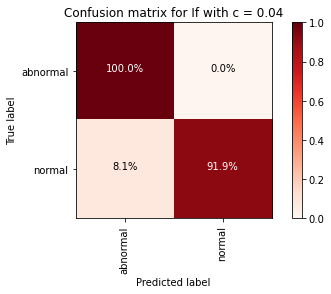

In [13]:
cm_if = confusion_matrix(y_test, y_pred)
print(f"Finished trainning in {t} seconds")
print(f"AUC: {roc_auc_score(y_test, y_pred):.1%}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(cm_if, f"Confusion matrix for If with c = {cmax}")

In [15]:
print(f"tp: {tp}\t fp: {fp}")

tp: 8583	 fp: 38568.0


In [5]:
rs = [0.02, 0.03, 0.04, 0.05]
ts = []
auc= []
fps = []
tps = []
f1 = []
cms = []
for r in rs:
    target_anomaly_rate = r
    n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
    df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
    df_sample = df_sample.sample(frac=1, random_state=1)
    anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
    print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

    df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
    toDecode = ["protocol_type", "service", "flag", "target"]
    leSF = preprocessing.LabelEncoder()
    for f in toDecode:
        df_sample[f] = leSF.fit_transform(df_sample[f])

    x_train, x_test, y_train, y_test = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.33, random_state=0)
    contamination = [round(r + 0.01*i, 2) for i in range(1, 10)]
    cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contamination, silent=True)
    
    cm_if = confusion_matrix(y_test, y_pred)
    print(f"AUC: {roc_auc_score(y_test, y_pred):.1%}")
    print(classification_report(y_test, y_pred))
    ts.append(t)
    auc.append(roc_auc_score(y_test, y_pred))
    fps.append(fp)
    tps.append(tp)
    f1.append(f)
    cms.append(cm_if)
    print(f"[{t}] contamination: {cmax}\t tp: {tp}\t fp:{fp}")
    print(f"f1: {f:.3} \t auc: {roc_auc_score(y_test, y_pred):.3}")
    print(cm_if)

anomaly rate is 2.0% out of 992633 records (19853)
AUC: 95.4%
              precision    recall  f1-score   support

          -1       0.18      1.00      0.30      6503
           1       1.00      0.91      0.95    321066

    accuracy                           0.91    327569
   macro avg       0.59      0.95      0.63    327569
weighted avg       0.98      0.91      0.94    327569

[0:01:31.801529] contamination: 0.07	 tp: 6501	 fp:29735.0
f1: 0.304 	 auc: 0.954
[[  6501      2]
 [ 29735 291331]]
anomaly rate is 3.0% out of 1002866 records (30086)
AUC: 95.3%
              precision    recall  f1-score   support

          -1       0.25      1.00      0.40      9934
           1       1.00      0.91      0.95    321012

    accuracy                           0.91    330946
   macro avg       0.62      0.95      0.68    330946
weighted avg       0.98      0.91      0.93    330946

[0:01:30.224440] contamination: 0.11	 tp: 9927	 fp:29786.0
f1: 0.4 	 auc: 0.953
[[  9927      7]
 [ 2978

tp: 6501 fp: 29735.0


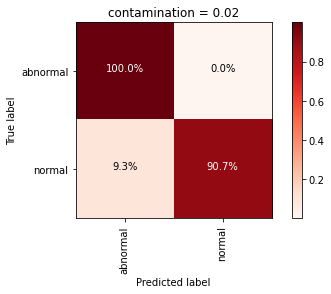

In [10]:
print(f"tp: {tps[0]} fp: {fps[0]}")
plot_confusion_matrix(cms[0], f"contamination = {rs[0]}")

tp: 9927 fp: 29786.0


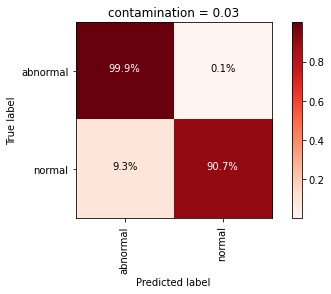

In [12]:
print(f"tp: {tps[1]} fp: {fps[1]}")
plot_confusion_matrix(cms[1], f"contamination = {rs[1]}")

tp: 13309 fp: 30153.0


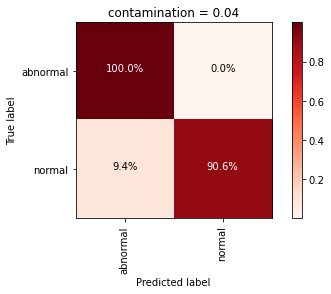

In [13]:
print(f"tp: {tps[2]} fp: {fps[2]}")
plot_confusion_matrix(cms[2], f"contamination = {rs[2]}")

tp: 8583 fp: 38568.0


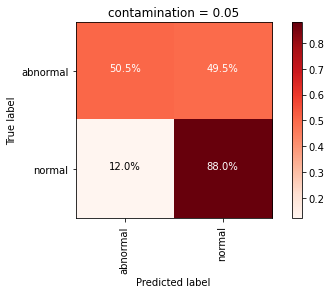

In [14]:
print(f"tp: {tps[3]} fp: {fps[3]}")
plot_confusion_matrix(cms[3], f"contamination = {rs[3]}")

anomaly rate is 5.0% out of 1023979 records (51199)
Finished trainning in 0:01:33.780120 seconds
contamination: 0.11 	 tp: 8583/support: 17004/predicted: 37120 -> fp = 28537
AUC : 70.8% 	 precision: 0.231 	 recall: 0.505 	 f1: 0.3171605941911167
--------------------
Finished trainning in 0:01:33.554381 seconds
contamination: 0.12 	 tp: 8583/support: 17004/predicted: 40441 -> fp = 31858
AUC : 70.3% 	 precision: 0.212 	 recall: 0.505 	 f1: 0.2988249630080947
--------------------
Finished trainning in 0:01:33.462066 seconds
contamination: 0.13 	 tp: 8583/support: 17004/predicted: 43781 -> fp = 35198
AUC : 69.8% 	 precision: 0.196 	 recall: 0.505 	 f1: 0.28240519865098296
--------------------
Finished trainning in 0:01:33.657715 seconds
contamination: 0.14 	 tp: 8583/support: 17004/predicted: 47151 -> fp = 38568
AUC : 69.2% 	 precision: 0.182 	 recall: 0.505 	 f1: 0.26757072714519525
--------------------
Finished trainning in 0:01:33.613250 seconds
contamination: 0.15 	 tp: 8583/support: 1

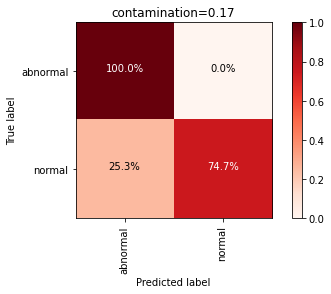

In [17]:
r = 0.05
n_records = int(np.ceil(len(df.loc[df["target"]=='normal.'])*r/(1-r)))
df_sample = df.loc[df["target"]=='normal.'].append(df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1))
df_sample = df_sample.sample(frac=1, random_state=1)
anomaly_rate = 1.0 - len(df_sample.loc[df_sample["target"]=='normal.'])/len(df_sample)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df_sample)} records ({n_records})")

df_sample['binary_target'] = [1 if x=='normal.' else -1 for x in df_sample["target"]]
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df_sample[f] = leSF.fit_transform(df_sample[f])

x_train, x_test, y_train, y_test = train_test_split(df_sample.drop(["target", 'binary_target'], axis=1), df_sample['binary_target'], test_size=0.33, random_state=0)

contamination = [round(0.1 + 0.01*i, 2) for i in range(1, 20)]
cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contamination, silent=False)

cm_if = confusion_matrix(y_test, y_pred)
print(f"AUC: {roc_auc_score(y_test, y_pred):.1%}")
print(classification_report(y_test, y_pred))
print(f"tp:{tp}\t fp:{fp}")
plot_confusion_matrix(cm_if, f"contamination={cmax}")

Finished trainning in 0:01:34.080174 seconds
AUC: 93.7%
              precision    recall  f1-score   support

          -1       0.30      1.00      0.46     17004
           1       1.00      0.87      0.93    320910

    accuracy                           0.88    337914
   macro avg       0.65      0.94      0.69    337914
weighted avg       0.96      0.88      0.91    337914



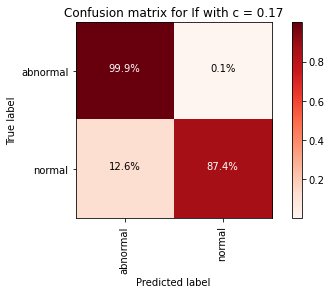

In [18]:
s = datetime.datetime.now()
y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=0.17).fit(x_train).predict(x_test)
t = datetime.datetime.now() - s

cm_if = confusion_matrix(y_test, y_pred)
print(f"Finished trainning in {t} seconds")
print(f"AUC: {roc_auc_score(y_test, y_pred):.1%}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(cm_if, f"Confusion matrix for If with c = {cmax}")